In [63]:
# parameters
INPUT_DATA_PATH = "../data/interim/"
INPUT_PROCESSED_DATA_PATH = "../data/processed/"

YEAR = 2017
SAVE_OUTPUT = True
OUTPUT_DATA_PATH = "../data/processed/"
OUTPUT_FIGURES_PATH = "../reports/figures/"

In [64]:
# Parameters
YEAR = 2024 
SAVE_OUTPUT = True


In [65]:
# Import all necessary libraries
import time
start = time.time()
import geopandas as gpd
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import seaborn as sns

import warnings
from pathlib import Path

# Plot AADBT_DIFF using plotly express
import plotly.express as px

# Load data

In [66]:
# Read BiciZen prediction 
bicizen_aadbt = pd.read_parquet(Path(INPUT_PROCESSED_DATA_PATH) / f"bicizen_aadbt.parquet")
print(bicizen_aadbt.shape)
print(bicizen_aadbt.columns)
bicizen_aadbt.head(5)

(26, 5)
Index(['Year', 'ROOT_ID', 'ATT', 'ATT_in_Million', 'AADBT'], dtype='object')


,Year,ROOT_ID,ATT,ATT_in_Million,AADBT
0,2024,1029389,903375.899687,0.903376,2475.002465
1,2024,1046328,235286.266375,0.235286,644.619908
2,2024,1046333,80525.583573,0.080526,220.618037
3,2024,1046343,126998.308625,0.126998,347.940572
4,2024,1047953,865768.419524,0.865768,2371.968273


In [67]:
# Read BiciZen station
bicizen_sation = gpd.read_parquet(Path(INPUT_DATA_PATH) / f"bicizen/bicizen_stations.parquet")
print(bicizen_sation.shape)
print(bicizen_sation.columns)
bicizen_sation.head(5)

(55, 9)
Index(['ROOT_ID', 'Desc_aforament', 'direction_counter', 'directionality',
       'geometry', 'id', 'DaysWithData', 'HasWeekendData', 'Observations'],
      dtype='object')


,ROOT_ID,Desc_aforament,direction_counter,directionality,geometry,id,DaysWithData,HasWeekendData,Observations
0,1060335,C/ Bilbao,NW,NaN,POINT (433211.182 4583998.871),NaN,1,False,2
1,1048229,C/ de Bilbao 117,SE,NaN,POINT (433211.182 4583998.871),NaN,2,False,3
2,1048249,Rambla de l'Onze de Setembre 2,W,NaN,POINT (432725.306 4586854.582),NaN,1,True,2
3,1048273,C/ de Pi i Margall 114,N,NaN,POINT (430189.262 4584777.934),NaN,33,True,40
4,1048896,C/ Jocs Florals 175,SE,NaN,POINT (427815.131 4580216.804),NaN,16,False,18


In [68]:
# Read BiciZen prediction 
counters=pd.read_parquet(Path(INPUT_PROCESSED_DATA_PATH) /"counter_aadbt2024.parquet")
# counters=gpd.read_parquet(Path(INPUT_PROCESSED_DATA_PATH) /"013_oriented_stations2023.parquet")
counters=counters.rename(columns={"Id_aforament": "id"})
print(counters.shape)
print(counters.columns)

counters.head(5)


(327, 3)
Index(['id', 'AADBT', 'Number_of_days'], dtype='object')


,id,AADBT,Number_of_days
0,20001,3916.892128,343
1,20002,7152.887387,222
2,20003,3816.694268,157
3,20005,3055.405109,274
4,20006,2599.983660,306


# Merge data

In [69]:
#Manage BiciZen AADBT
bicizen_aadbt.rename(columns={"AADBT":"AADBT_BICIZEN"}, inplace=True)
bicizen_aadbt=bicizen_aadbt[['ROOT_ID', 'AADBT_BICIZEN']]

#Manage biciZen Stations
bicizen_sation[['ROOT_ID', 'id',  'direction_counter', 'geometry']]
bicizen_sation["id"] = bicizen_sation["id"].fillna(-1).astype(int)

#Manage counts
counters.rename(columns={"AADBT":"AADBT_COUNTER"}, inplace=True)
counters=counters[['id','AADBT_COUNTER']]

In [70]:
# Merge bicizen_aadbt and bicizen_sation on 'ROOT_ID'
merged_df = pd.merge(bicizen_aadbt, bicizen_sation, on='ROOT_ID')

# Merge the result with counters on 'id'
final_df = pd.merge(merged_df, counters, on='id')
final_df=final_df[['ROOT_ID','id',  'AADBT_BICIZEN','AADBT_COUNTER', 
'direction_counter','DaysWithData', 'HasWeekendData', 'Observations',
                   'geometry']]

# Calculate the difference
final_df['AADBT_DIFF'] = final_df['AADBT_BICIZEN'] - final_df['AADBT_COUNTER']

# Display the merged dataframe
print(final_df.shape)
print(final_df.columns)

final_df.head(5)


(9, 10)
Index(['ROOT_ID', 'id', 'AADBT_BICIZEN', 'AADBT_COUNTER', 'direction_counter',
       'DaysWithData', 'HasWeekendData', 'Observations', 'geometry',
       'AADBT_DIFF'],
      dtype='object')


,ROOT_ID,id,AADBT_BICIZEN,AADBT_COUNTER,direction_counter,DaysWithData,HasWeekendData,Observations,geometry,AADBT_DIFF
0,1046328,20404,644.619908,1112.157051,NW,10,False,13,POINT (426616.254 4583734.058),-467.537143
1,1048223,20248,1521.260065,5002.151603,N,11,False,13,POINT (432061.273 4584212.752),-3480.891538
2,1048268,20347,385.748172,1185.923567,SW,33,True,42,POINT (430852.232 4585230.121),-800.175395
3,1048272,20241,504.319493,1953.168790,N,13,False,13,POINT (426382.214 4581269.343),-1448.849297
4,1048274,20099,1342.547186,4860.427326,NE,31,True,43,POINT (430235.035 4584150.178),-3517.880140


In [71]:
final_df.describe()

,ROOT_ID,id,AADBT_BICIZEN,AADBT_COUNTER,DaysWithData,Observations,AADBT_DIFF
count,9.000000e+00,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,1.049267e+06,20244.000000,941.036452,2699.885942,20.666667,26.000000,-1758.849489
std,2.448706e+03,108.983944,472.907782,1857.830689,9.643651,13.647344,1439.508449
min,1.046328e+06,20098.000000,385.748172,1112.157051,10.000000,13.000000,-3893.124997
25%,1.048268e+06,20169.000000,556.079858,1488.991176,13.000000,13.000000,-3480.891538
50%,1.048274e+06,20242.000000,826.345709,1617.548077,17.000000,23.000000,-1061.468219
75%,1.049380e+06,20347.000000,1342.547186,4860.427326,31.000000,40.000000,-662.645468
max,1.054514e+06,20404.000000,1674.280251,5567.405248,33.000000,43.000000,-467.537143


# Compare AADBT

### Explore value

In [72]:
# Describe the columns

# Create a boxplot for each column
# Multiply the difference by -1
final_df['AADBT_DIFF'] = final_df['AADBT_DIFF'] * -1

# Create a boxplot for each column
fig = px.box(final_df, y=['AADBT_BICIZEN', 'AADBT_COUNTER', 'AADBT_DIFF'], title='Boxplot of control locations difference in AADBT Values')
fig.show()

final_df['AADBT_DIFF'] = final_df['AADBT_DIFF'] * -1


### Detect zeros

In [73]:
print(final_df.shape)
problem=final_df[final_df['AADBT_BICIZEN']==0]["ROOT_ID"]
final_df=final_df[~final_df["ROOT_ID"].isin(problem)]
final_df.shape


(9, 10)


(9, 10)

In [74]:
problem=final_df[final_df['AADBT_COUNTER']==0]["id"]
final_df=final_df[~final_df["id"].isin(problem)]
final_df.shape

(9, 10)

## Plots

In [75]:
# Calculate the difference

# Order by difference
final_df = final_df.sort_values(by='AADBT_DIFF', ascending=False)

final_df["Locations"] =  + final_df["direction_counter"]

fig = px.bar(final_df, x='AADBT_DIFF', y='Locations', orientation='h', title='Difference between AADBT_BICIZEN and AADBT_COUNTER', labels={'id': 'ID', 'AADBT_DIFF': 'AADBT_DIFF'})
fig.update_layout(yaxis={'categoryorder':'total ascending', 'tickmode':'linear'})
fig.show()


In [76]:
import plotly.express as px
# Calculate averages
avg_bicizen = final_df['AADBT_BICIZEN'].mean()
avg_counter = final_df['AADBT_COUNTER'].mean()

# Create a scatter plot with Plotly Express (axes inverted)
fig = px.scatter(
    final_df,
    x='AADBT_BICIZEN',  # Inverted axis
    y='AADBT_COUNTER',  # Inverted axis
    title='Comparison of AADBT values in control locations between BiciZen and Counters',
    labels={'AADBT_BICIZEN': 'AADBT_BICIZEN', 'AADBT_COUNTER': 'AADBT_COUNTER', 'ROOT_ID': 'ROOT_ID'},
    opacity=0.7,
    trendline='ols', trendline_color_override='darkblue'
)

# Add average lines
fig.add_shape(
    type='line',
    x0=avg_counter,
    x1=avg_counter,
    y0=0,
    y1=10000,
    line=dict(color='blue', dash='dash'),
    name='Average AADBT_COUNTER'
)
fig.add_shape(
    type='line',
    x0=0,
    x1=10000,
    y0=avg_bicizen,
    y1=avg_bicizen,
    line=dict(color='red', dash='dash'),
    name='Average AADBT_BICIZEN'
)

# Update axis ranges
fig.update_layout(xaxis=dict(range=[0, 10000]), yaxis=dict(range=[0, 10000]))

fig.update_layout(
    width=750,
    height=750
)
fig.show()


In [77]:
import plotly.express as px
# Calculate averages
avg_bicizen = final_df['AADBT_BICIZEN'].mean()
avg_counter = final_df['AADBT_COUNTER'].mean()

# Create a scatter plot with Plotly Express (axes inverted)
fig = px.scatter(
    final_df,
    x='AADBT_COUNTER',  # Inverted axis
    y='AADBT_BICIZEN',  # Inverted axis
    title='Comparison of AADBT values in control locations between BiciZen and Counters',
    labels={'AADBT_BICIZEN': 'AADBT_BICIZEN', 'AADBT_COUNTER': 'AADBT_COUNTER', 'ROOT_ID': 'ROOT_ID'},
    opacity=0.7,
    trendline='ols', trendline_color_override='darkblue'
)

# Add average lines
fig.add_shape(
    type='line',
    x0=avg_counter,
    x1=avg_counter,
    y0=0,
    y1=10000,
    line=dict(color='blue', dash='dash'),
    name='Average AADBT_COUNTER'
)
fig.add_shape(
    type='line',
    x0=0,
    x1=10000,
    y0=avg_bicizen,
    y1=avg_bicizen,
    line=dict(color='red', dash='dash'),
    name='Average AADBT_BICIZEN'
)

# Update axis ranges
fig.update_layout(xaxis=dict(range=[0, 10000]), yaxis=dict(range=[0, 10000]))

fig.update_layout(
    width=750,
    height=750
)
fig.show()


In [78]:
import plotly.express as px
scaled = final_df.copy()
scaled['AADBT_BICIZEN'] = 3.266 * scaled['AADBT_BICIZEN'] -477.175
# Calculate averages
avg_bicizen = scaled['AADBT_BICIZEN'].mean()
avg_counter = scaled['AADBT_COUNTER'].mean()

# Create a scatter plot with Plotly Express (axes inverted)
fig = px.scatter(
    scaled,
    x='AADBT_COUNTER',  # Inverted axis
    y='AADBT_BICIZEN',  # Inverted axis
    title='Comparison of scaled AADBT values in control locations between BiciZen and Counters',
    labels={'AADBT_BICIZEN': 'AADBT_BICIZEN', 'AADBT_COUNTER': 'AADBT_COUNTER', 'ROOT_ID': 'ROOT_ID'},
    opacity=0.7,
    trendline='ols', trendline_color_override='darkblue'
)

# Add average lines
fig.add_shape(
    type='line',
    x0=avg_counter,
    x1=avg_counter,
    y0=0,
    y1=10000,
    line=dict(color='blue', dash='dash'),
    name='Average AADBT_COUNTER'
)
fig.add_shape(
    type='line',
    x0=0,
    x1=10000,
    y0=avg_bicizen,
    y1=avg_bicizen,
    line=dict(color='red', dash='dash'),
    name='Average AADBT_BICIZEN'
)

# Update axis ranges
fig.update_layout(xaxis=dict(range=[0, 10000]), yaxis=dict(range=[0, 10000]))

fig.update_layout(
    width=750,
    height=750
)
fig.show()


In [79]:
final_df['AADBT_DIFF'].describe()

count       9.000000
mean    -1758.849489
std      1439.508449
min     -3893.124997
25%     -3480.891538
50%     -1061.468219
75%      -662.645468
max      -467.537143
Name: AADBT_DIFF, dtype: float64

In [80]:
final_df["ROOT_ID"].unique()

array([1046328, 1054514, 1048280, 1048268, 1051865, 1048272, 1048223,
       1048274, 1049380], dtype=int64)

### Explore correlation

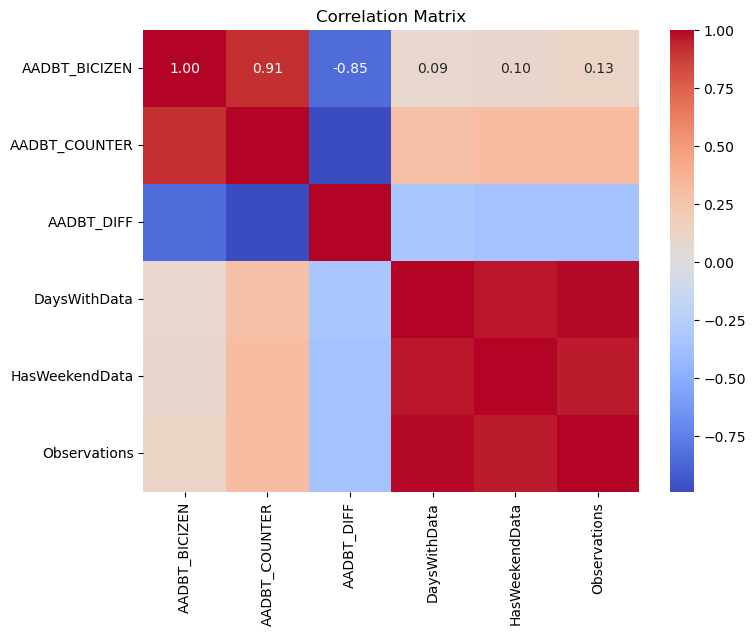

In [81]:
# Calculate the correlation matrix
correlation_matrix = final_df[['AADBT_BICIZEN', 'AADBT_COUNTER', 'AADBT_DIFF','DaysWithData', 'HasWeekendData', 'Observations']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

c:\Users\lucal\anaconda3\envs\ridership_model\Lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



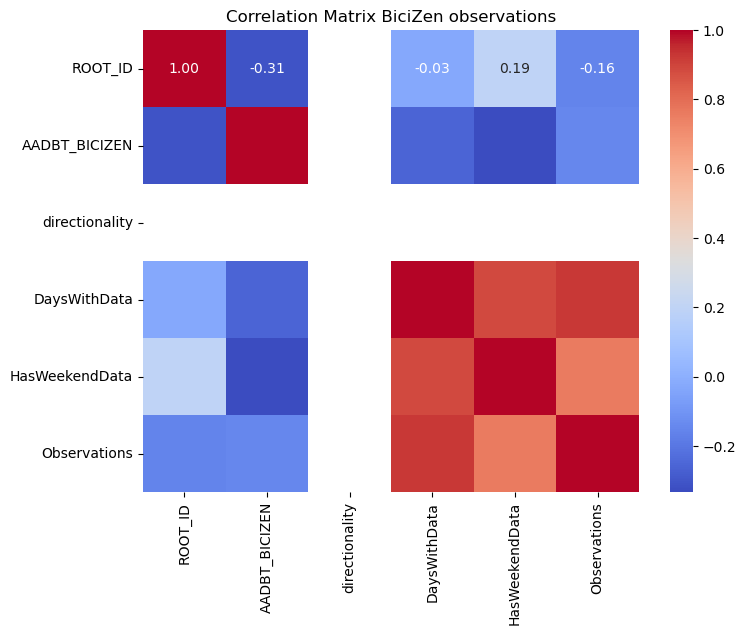

In [82]:
# Calculate the correlation matrix for numeric attributes in merged_df
correlation_numeric = merged_df.select_dtypes(include=['float64', 'int64','bool']).corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix BiciZen observations')
plt.show()

## Ger problematic values

In [83]:
final_df=final_df[['ROOT_ID', 'AADBT_DIFF',  'AADBT_BICIZEN', 'AADBT_COUNTER',
       'direction_counter', 'DaysWithData',
       'HasWeekendData', 'Observations', 'geometry',  'Locations']]
final_df.sort_values(by="AADBT_DIFF").head(16)

,ROOT_ID,AADBT_DIFF,AADBT_BICIZEN,AADBT_COUNTER,direction_counter,DaysWithData,HasWeekendData,Observations,geometry,Locations
6,1049380,-3893.124997,1674.280251,5567.405248,SW,31,True,40,POINT (430235.035 4584150.178),SW
4,1048274,-3517.880140,1342.547186,4860.427326,NE,31,True,43,POINT (430235.035 4584150.178),NE
1,1048223,-3480.891538,1521.260065,5002.151603,N,11,False,13,POINT (432061.273 4584212.752),N
3,1048272,-1448.849297,504.319493,1953.168790,N,13,False,13,POINT (426382.214 4581269.343),N
7,1051865,-1061.468219,556.079858,1617.548077,NE,27,True,34,POINT (430852.232 4585230.121),NE
2,1048268,-800.175395,385.748172,1185.923567,SW,33,True,42,POINT (430852.232 4585230.121),SW
5,1048280,-662.645468,826.345709,1488.991176,SE,17,False,23,POINT (429003.890 4580413.799),SE
8,1054514,-497.073205,1014.127432,1511.200637,S,13,False,13,POINT (426382.214 4581269.343),S
0,1046328,-467.537143,644.619908,1112.157051,NW,10,False,13,POINT (426616.254 4583734.058),NW


# Save output

In [85]:
final_df=final_df[['ROOT_ID',   'AADBT_COUNTER','AADBT_BICIZEN']]
final_df.to_csv(Path(OUTPUT_DATA_PATH) / f"biciZen_aadbt_diff_{YEAR}.csv", index=False)